## 1 Human capital accumulation

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm
import matplotlib.pyplot as plt
sm.init_printing(use_unicode=True)
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual 
import matplotlib.ticker as ticker

## 1.1

First we set the parameters and vector given in the assignment

In [2]:
rho = 2 
beta = 0.96 
gamma = 0.1 
w=2
b=1
Delta = 0.1
h_vec = np.linspace(0.1,1.5,100)

Next, we define the functions for utility, disutility, consumption and $v_2$

In [3]:
def disutility_of_working(gamma,l):
    if l==1: 
        return gamma*l
    if l==0:
        return 0
    
def c(w,h,l,b):
    if l == 1: 
        return w*h*l
    if l == 0:
        return b 
     
def utility(w,h,l,b,rho):
    return ((c(w,h,l,b))**(1-rho))/(1-rho)

def v2(c,rho,gamma,l,w,h,b):
    return utility(w,h,l,b,rho) - disutility_of_working(gamma,l)

We solve for which values of humancapital the worker wants to work in periode 2. 
In addition we find the utility she gets based on her choice to work or not.

In [4]:
def solve_period_2(rho,gamma,w):
    # a. we create empty vectors for utility and labour  
    l2_vec = np.empty(100)
    v2_vec = np.empty(100)

    # b. We solve if she wants to work for each level of humancapital in the vector
    for i,h in enumerate(h_vec):
        if (v2(c,rho,gamma,0,w,h,b)>v2(c,rho,gamma,1,w,h,b)) == True: 
            l2_vec[i]=0
        else: 
            l2_vec[i]=1
        v2_vec[i]=v2(c,rho,gamma,l2_vec[i],w,h,b)
    return  l2_vec , v2_vec



We run the function and save the output

In [5]:
l2_vec , v2_vec=solve_period_2(rho,gamma,w)

We illustrate the solution by plotting utility and labour as a function of humancapital

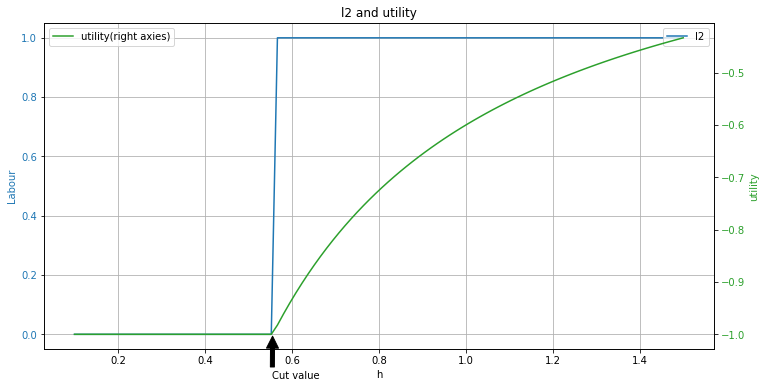

In [11]:
#Plot
fig_u2 = plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,1,1)

color = 'tab:blue'
ax1.set_xlabel('h')
ax1.set_ylabel('Labour', color=color)
ax1.plot(h_vec, l2_vec, color=color, label='l2')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('utility', color=color)  # we already handled the x-label with ax1
ax2.plot(h_vec, v2_vec, color=color, label='utility(right axies)')
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()
ax1.grid()

ax1.set_title('l2 and utility')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
ax1.grid(True)

ax1.annotate('Cut value', 
            xy=(0.555556, 0), 
            xytext=(0.555, -0.15), 
            arrowprops = dict(facecolor='black', shrink=0.05))
# otherwise the right y-label is slightly clipped
plt.show()

Here we see that for a value of 0.55 and above of human capital the worker chooses to work, and their utility is increasing. We note that utility of worker is negative, tough this seems counter intutive we remeber that utility is ordinal, hence we can only say that on situation is better than another. 

To get the exact value of humancapital where the worker goes from not working to working we define the function below

In [12]:
def skif_h2(rho,gamma,w,b):
    obj = lambda h: (v2(c,rho,gamma,0,w,h,b)-v2(c,rho,gamma,1,w,h,b))**2; 
    x0=1.5
    result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[0.1,1.5])
    h_skift=result.x
    return h_skift

In [13]:
skift_h2=skif_h2(rho,gamma,w,b)
print(skift_h2,v2(c,rho,gamma,1,w,skift_h2,b))

0.5555561544857957 -0.9999990297340571


We see here that the exact level of humancapital where the worker starts working is 0.555556 and here in this point get the utility -0.999

## Question 1.2

We now solve for period 1. We use a similar approach as in question 1. Firstly we define a function for the expected utility in period 2 and then we define the utility in period 1.

In [14]:
def expected_v2(h1,l1,Delta,v2_interp):
    #a. first we see the case where h2 contains delta 
    h2_high=(h1+l1+Delta)
    v2_high=v2_interp([h2_high])[0]
    
    #b. then we see the case where case h2 doesn't contain delta     
    h2_low=(h1+l1+0)
    v2_low=v2_interp([h2_low])[0]
    
    #c. we then find the expected value of period 2
    expected_v2 = 0.5*v2_high + 0.5*v2_low
    return expected_v2
 
# We then define a function that finds the value of v1    
def v1(w,h1,l1,b,rho,gamma,Delta,v2_interp):
    #Firstly we define the utility obtained only in period 1 
    Utility_period_1=utility(w,h1,l1,b,rho) - disutility_of_working(gamma,l1)
    
    #Then we define the utility obtained only in period 1 and the expected utility for period 2
    v1 = Utility_period_1 + beta*expected_v2(h1,l1,Delta,v2_interp)
    return v1
    

We then define the function to solve periode 1. Here we use interpolation for the values of v2. 

In [15]:
def solve_period_1(w,h1,b,rho,gamma,Delta):
    
    # a. First we create the vector used to contain the data 
    l1_vec = np.empty(100)
    v1_vec = np.zeros(100)
    v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)


    # b. Then we find if the worker wants to work for each h2 in vector
    for i,h1 in enumerate(h_vec):
        if (v1(w,h1,0,b,rho,gamma,Delta,v2_interp)>v1(w,h1,1,b,rho,gamma,Delta,v2_interp)) == True:
            l1_vec[i]=0
        else: 
            l1_vec[i]=1
        v1_vec[i] = v1(w,h1,l1_vec[i],b,rho,gamma,Delta,v2_interp)
    return l1_vec , v1_vec             



We run the function and save the output

In [16]:
l1_vec , v1_vec=solve_period_1(w,h_vec,b,rho,gamma,Delta)

Just as in question 1 we find the exact point of humancapital for which the worker redecides if she wants to work.

In [17]:
def skif_h1(rho,gamma,w,b):
    v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)
    obj = lambda h: (v1(w,h,0,b,rho,gamma,Delta,v2_interp)-v1(w,h,1,b,rho,gamma,Delta,v2_interp))**2; 
    x0=1.5
    result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[0.1,1.5])
    h_skift=result.x
    return h_skift



In [18]:
v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)
skift_h1=skif_h1(rho,gamma,w,b)
print(skift_h1,v1(w,skift_h1,1,b,rho,gamma,Delta,v2_interp))

0.3518300411358104 -1.9599950825692343


We plot these results as in question 1 and get: 

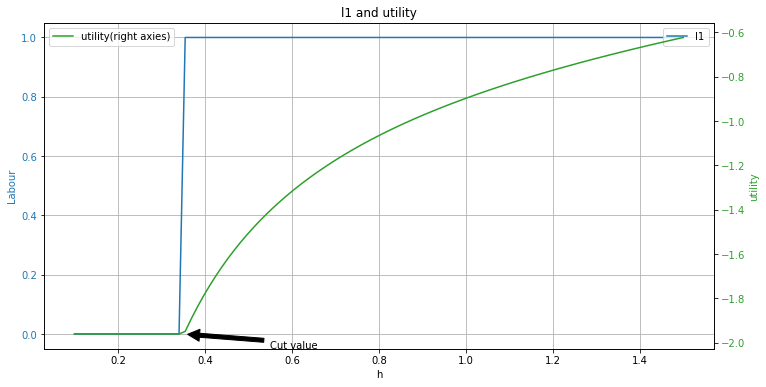

In [19]:
fig_u1 = plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,1,1)

color = 'tab:blue'
ax1.set_xlabel('h')
ax1.set_ylabel('Labour', color=color)
ax1.plot(h_vec, l1_vec, color=color, label='l1')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('utility', color=color)  # we already handled the x-label with ax1
ax2.plot(h_vec, v1_vec, color=color, label='utility(right axies)')
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()
ax1.grid()

ax1.set_title('l1 and utility')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
ax1.grid(True)

ax1.annotate('Cut value', 
            xy=(0.35, 0), 
            xytext=(0.55, -0.05), 
            arrowprops = dict(facecolor='black', shrink=0.05))
# otherwise the right y-label is slightly clipped
plt.show()



We see here that worker wants to work when she has a level of humancapital which is 0.35. This level is lower than in questions 1, because her decision now will affect future earings though the level of humancapital in period 2. 

## Question 1.3
In this question we wants to see if the worker will never work if the potential wage income is lower than the unemployment benefits. We look at period 1, because if she wants to work in period 1 she will also work in period 2. To solve this we define a function as in question 1 and 2, but where the unemployment benefits are now in a vector instead of humancapital. We use humancapital and wage as the only input in this function so it can be interactively changed in the graph. This way the problem can be analyzed for multiple values of humancapital and wages

In [20]:
def _solve_p3(h,w_input):
    #a. First we create the empty vectors and a vector for the benefits
    l3_vec=np.empty(100)
    v3_vec = np.zeros(100)
    b_vec = np.linspace(1,5,100)
    v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)


    # b. The we solve the problem for all the b's in the vector
    for i,j in enumerate(b_vec):
        if (v1(w_input,h,0,j,rho,gamma,Delta,v2_interp)>v1(w_input,h,1,j,rho,gamma,Delta,v2_interp)) == True:
            l3_vec[i]=0
        else: 
            l3_vec[i]=1
        v3_vec[i] = v1(w_input,h,l3_vec[i],b_vec[i],rho,gamma,Delta,v2_interp)
    
    
    
    #We then plot the graph (The rest of the code in this box is for the graph)
    fig_u2 = plt.figure(figsize=(12,6))
    ax1 = plt.subplot(1,1,1)

    color = 'tab:blue'
    ax1.set_xlabel('b')
    ax1.set_ylabel('labor', color=color)
    ax1.plot(b_vec, l3_vec, color=color, label='l1')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('utility', color=color)  # we already handled the x-label with ax1
    ax2.plot(b_vec, v3_vec, color=color, label='utility(right axies)')
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.grid()

    ax1.set_title('l1 and utility')
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax1.grid(True)



We plot the output of the functions

Please note that we have had trouble running two interactive plots in one notebook. The interactive plots seem to refer to one another. If you cannot use the sliders, please restart kernal.

In [22]:
 plot1 = interact(_solve_p3,
    h=widgets.FloatSlider(description='h_capital',min=0.1, max=1.50,step=0.1,value=1.5),
    w_input=widgets.FloatSlider(description='Wage',min=0.1, max=10,step=0.1,value=2)
    );  
plot1

interactive(children=(FloatSlider(value=1.5, description='h_capital', max=1.5, min=0.1), FloatSlider(value=2.0…

<function __main__._solve_p3(h, w_input)>

We see from the graphs that the worker will actually work in period 1 in cases where the wage is lower than the unemployment benefits. As seen by using the interactive sliders an increase in the level of humancapital will increase the workers willingness to work.

# 2 AS-AD model

In [19]:
# Define parameters as symbols
h= sm.symbols('h')
alpha = sm.symbols('alpha')
v = sm.symbols('v')
beta = sm.symbols('beta')
gamma = sm.symbols('gamma')
phi = sm.symbols('phi')
s_t = sm.symbols('s_t')
s_t1 = sm.symbols('s_t1')
y_t = sm.symbols('y_t')
y_t1 = sm.symbols('y_t1')
pi_t = sm.symbols('pi_t')
pi_t1 = sm.symbols('pi_t1')

## 2.1
First we define the AD and SRAS curve as given in the assignment. 

In [20]:
#Define AD and SRAS curve as and equation
equi = sm.Eq(((1/(h*alpha))*(v-(1+beta*alpha)*y_t)),(pi_t1+gamma*y_t-phi*gamma*y_t1+s_t-phi*s_t1))

Now we use sympy to solve the equation. If we were to this by hand it would be similar to setting the AD curve equal to the SRAS curve, that is
$$
\frac{1}{h\alpha}[v_{t}-(1+\alpha b)y_{t}] = \pi_{t-1} + \gamma y_{t} - \phi \gamma y_{t-1} + s_{t} - \phi s_{t-1}
$$
And isolate for $y$. That breeds the following expression $y^{\star}$:

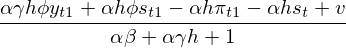

In [21]:
y_star = sm.solve(equi,y_t)[0]
y_star

Now we need an expression for $\pi^{\star}$. We subsitutite $y^{\star}$ into the AD curve at isloate for $\pi$. This means that python solves the following for us

$$
\pi^{\star} = \frac{1}{h\alpha}\bigg[v_{t}-(1+\alpha b)\frac{\alpha\gamma h \phi y_{t-1} + \alpha h \phi s_{t-1} - \alpha h \pi_{t-1} - \alpha h s_{t} + v}{\alpha h \gamma +\alpha\beta + 1}\bigg]
$$
This gives us

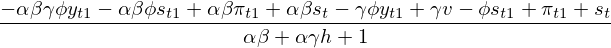

In [22]:
AD = sm.Eq(pi_t,(1/(h*alpha)*(v-(1+beta*alpha)*y_star)))
pi_star = sm.solve(AD,pi_t)[0]
pi_star

## 2.2
Now we are asked to consider how the equilibrium changes when $v$ goes from and initial value of 0 to a new value of 0.1, all else equal.

In [23]:
# a. Define parameters as given in the assignemnt
par = {}
par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075
par['s_t'] = 0.0

# b. Define variables for period 1
y_t1 = 0
pi_t1 = 0
v_1 = 0 
s_t = 0
s_t1 = 0 

# c. Define new value of v, remembering that all else are equal
v2 = 0.1

# d. Calculate AD1(v=0), SRAS and AD2(v=0.1)
AD1 = sm.Eq(pi_t,(1/(par['h']*par['alpha'])*(v_1-(1+par['b']*par['alpha'])*y_t)))
SRAS = sm.Eq(pi_t,(pi_t1+par['gamma']*y_t-par['phi']*par['gamma']*y_t1+s_t-par['phi']*s_t1))
AD2 = sm.Eq(pi_t,(1/(par['h']*par['alpha'])*(v2 -(1+par['b']*par['alpha'])*y_t)))

print(f'AD with v=0:{AD1}, AD with v=0.1:,{AD2}, SRAS:,{SRAS}')

AD with v=0:Eq(pi_t, -1.34722222222222*y_t), AD with v=0.1:,Eq(pi_t, -1.34722222222222*y_t + 0.0347222222222222), SRAS:,Eq(pi_t, 0.075*y_t)


The AD and SRAS curves are determined as: 
$$ AD_{v = 0}: \quad \pi_t = -1.3472 y_t \\   $$
$$ AD_{v = 0.1}: \quad \pi_t = -1.3472 y_t + 0.03472 \\  $$
$$ SRAS: \quad \pi_t = 0.075 y_t \\   $$

Now we plot the three equations above to illustrate how the equilibrium shifts. Note that from the expressions above we have that $ \pi_t=\pi^{\star}$ when SRAS = AD. 

Text(0.05, 0.04, 'Equilibrium')

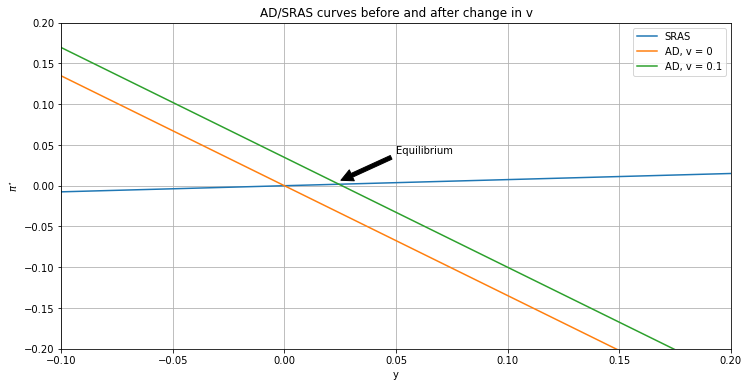

In [24]:
# Plot
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

y = np.linspace(-0.5, 0.5, 1000)
ax.plot(y, 0.075*y, label = 'SRAS')
ax.plot(y, -1.34722222 * y, label = 'AD, v = 0')
ax.plot(y, -1.34722222*y+0.0347222222222222, label = 'AD, v = 0.1')
plt.ylim(-0.2,0.2)
plt.xlim(-0.1,0.2)
ax.legend()
plt.ylabel('$\pi^{\star}$')
plt.xlabel('y')
ax.set_title('AD/SRAS curves before and after change in v')
ax.grid(True)
plt.annotate('Equilibrium',xy=(0.024,0.005), xytext=(0.05,0.04) ,arrowprops=dict(facecolor='black', shrink=0.05),)


### Comments
First, we see that our SRAS curve is sloping slightly upward which corresponds to the intuitive reasoning that supply increases as GDP($y$) increases. 
Both AD curves is downward sloping. in period 1 is in equilibrium where $y =0$. After the shock, we have a constant to our term for $\pi^{\star}$, as a result of the shock, where we have that $y = 0.024$, which is illustrated in the plot above. This means that the AD curve shifts to the right . This is also intuitive since v is demand disturbance. A positive demand disturbance means that the economy is hit by some sort of shock, hence the demand increases. This means that our results, as shown above, meet what one might think of intuitively 

## 3.1
Now are asked to consider how the economy changes when it is exposed to a shock in period $0$. The shock is again in the form of a positive demand disturbance. After period $0$ the shock disappears. However, vt is now defined as an AR process that is, $v_{t}=\delta v_{t-1} + x_{t}$, where $\delta = 0.8$. This means that the economy is still affected by the shock from period 0 in every period following. $80%$ of the shock 'stays' in the economy. This means that after the shock the economy converges back to its initial value. Let us investigate if that is the case

In [25]:
# Define parameters as dictionary
par = {}
alpha = par['alpha'] = 5.76
h = par['h'] = 0.5
beta = par['b'] = 0.5
phi = par['phi'] = 0
gamma = par['gamma'] = 0.075
s_t = par['s_t'] = 0.0
par['delta'] = 0.80
par['omega'] = 0.15


In [26]:
# Define variables as symbols
delta = sm.symbols('delta')
omega = sm.symbols('omega')
v_t = sm.symbols('v_t')
v_t1 = sm.symbols('v_t1')
s_t = sm.symbols('s_t')
s_t1 = sm.symbols('s_t1')
x_t = sm.symbols('x_t')
c_t = sm.symbols('c_t')

In [27]:
# Define the equilibrium values from question 1 as functions
def y_star(alpha,beta,gamma,h,phi,y_t1,s_t1,pi_t1,s_t,v):
    return (alpha*gamma*h*phi*y_t1 + alpha*h*phi*s_t1 + alpha*h*pi_t1 - alpha*h*0 + v)/(alpha*beta + alpha*gamma*h + 1)
    
def pi_star(alpha,beta,gamma,h,phi,y_t1,s_t1,pi_t1,s_t,v):
    return (-(alpha*beta*gamma*phi*y_t1)-(alpha*beta*phi*s_t1)+alpha*beta*pi_t1 + alpha*beta*0 - gamma*phi*y_t1 + gamma*v - phi*s_t1 + pi_t1 +0)/(alpha*beta + alpha*gamma*h + 1)    

Now we construct a loop that runs through 20 periods of v. This way we construct a vector in which we show the development of the shock. The plot serves to show how the shock 'dies' out as we mentioned in the introduction of this question. 

[0.1        0.08       0.064      0.0512     0.04096    0.032768
 0.0262144  0.02097152 0.01677722 0.01342177 0.01073742 0.00858993
 0.00687195 0.00549756 0.00439805 0.00351844 0.00281475 0.0022518
 0.00180144 0.00144115]


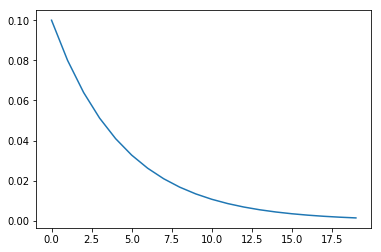

In [28]:
# a. Initialize vector with shock in first period. 
v_vec = np.empty(20)
v_vec[0] = 0.1

# b. Simulate to estimate effect of the shock
for i in range(1,20):
    v_t = par['delta']*v_vec[i-1]   
    v_vec[i] = v_t  

print(v_vec)
plt.plot(v_vec);

The plot above serves to show that the shock is converging towards 0.
By running the functions for equilibrium values for $y_t$ and $\pi_t$ with the newly defined v-vector of shocks and effects, we can illustrate how the economy evolves for the 20 periods following the shock. 

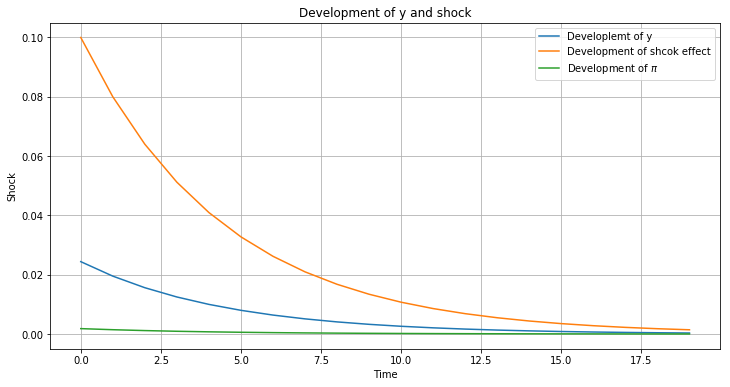

In [29]:
# a. Get array of y and pi for 20 periods following a shock
y_shock = [y_star(alpha,beta,gamma,h,phi,y_t1,s_t1,pi_t1,s_t,v) for v in v_vec]
pi_shock = [pi_star(alpha,beta,gamma,h,phi,y_t1,s_t1,pi_t1,s_t,v) for v in v_vec]

# b. Add variable that indicates periodes efter the shock
i = np.linspace(0,20,20)

# c. Create figure
fig_shock = plt.figure(figsize=(12,6))
ax = fig_shock.add_subplot(1,1,1)
ax.plot(y_shock, label = 'Developlemt of y')
ax.plot(v_vec, label = 'Development of shcok effect')
ax.plot(pi_shock, label = 'Development of $\pi$')
ax.set_title('Development of y and shock')
ax.legend(loc='upper right')
ax.set_xlabel('Time')
ax.set_ylabel('Shock')
ax.grid(True)

### Comments
First lets consider the equations from which the graphs has been derived:
$$y^{\star}=\frac{\alpha\gamma h \phi y_{t-1} + \alpha h \phi s_{t-1} - \alpha h \pi_{t-1} - \alpha h s_{t} + v}{\alpha h \gamma +\alpha\beta + 1}$$

and

$$\pi^{\star} = \frac{-\alpha \beta \gamma \phi y_{t-1} - \alpha\beta\phi s_{t-1} + \alpha \beta \pi_{t-1} + \alpha \beta s_{t} - \gamma \phi y_{t-1} + \gamma v - \phi s_{t-1} + \pi_{t-1} + s_{t}}{\alpha h \gamma + \alpha\beta + 1}$$

It is noted that throughout this simulation $s_{t}=0$.
We have now shown how the equilibrium values of $\pi$ and $y$ develop after the described shock appears. The effect on $y$ is much greater than the effect on $\pi$. This seems plausible as $v_{t}$ directly affects $y$ as we derived in question 1. Contrary to $y$, $v$ only affects $\pi$ through gamma which is 0.075. Hence it is trivial that the effect on $\pi$ from the shock is less than $y$. Further, we see that the effect of the shock converges to 0. This is also intuitive since only 80% of the shock effects the next period. In general, our findings correspond to the intuitive explanation laid forth in the beginning.

## 2.4
We are now asked to siumluate the model for 1000 periods and calculate the following
1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

In [30]:
# Set seed and add paramter values to dictionary
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2
seed=1986
np.random.seed(seed)

First we define $y^{\star}$ and $\pi^{\star}$ again. This time we do not consider a situation where $s_{t}=0$. Then we define a function that simulates the economy for N periods. 

In [31]:
def y_star(alpha,beta,gamma,h,phi,y_t1,s_t1,pi_t1,s_t,v):
    return (alpha*gamma*h*phi*y_t1 + alpha*h*phi*s_t1 + alpha*h*pi_t1 - alpha*h*s_t + v)/(alpha*beta + alpha*gamma*h + 1)

def pi_star(alpha,beta,gamma,h,phi,y_t1,s_t1,pi_t1,s_t,v):
    return (-(alpha*beta*gamma*phi*y_t1)-(alpha*beta*phi*s_t1)+alpha*beta*pi_t1 + alpha*beta*s_t - gamma*phi*y_t1 + gamma*v - phi*s_t1 + pi_t1 + s_t)/(alpha*beta + alpha*gamma*h + 1)    


In [32]:
def simulateASAD(alpha,beta,gamma,h,phi,N):
    # a. Define dynamic variables
    y_star_vec=np.empty(N)
    pi_star_vec=np.empty(N)
    v_vec = np.empty(N)
    s_vec = np.empty(N)
    
    # b. Set initial values to 0
    v_vec[0]=0
    s_vec[0]=0
    y_star_vec[0]=0
    pi_star_vec[0]=0
    v_t=0
    
    # c. Create shocks
    x_t = np.random.normal(0, par['sigma_x'], size=N)
    c_t = np.random.normal(0,par['sigma_c'], size=N)
    
    # d. simulate model N times and save results to vector
    for i in range(1,N):
        v_t = par['delta']*v_vec[i-1]+x_t[i] 
        v_vec[i] = v_t
        
        s_t=par['omega']*s_vec[i-1]+c_t[i]
        s_vec[i]=s_t
        
        y_star2=y_star(alpha,beta,gamma,h,phi,y_star_vec[i-1],s_vec[i-1],pi_star_vec[i-1],s_vec[i],v_vec[i])
        y_star_vec[i]=y_star2
        
        pi_star2=pi_star(alpha,beta,gamma,h,phi,y_star_vec[i-1],s_vec[i-1],pi_star_vec[i-1],s_vec[i],v_vec[i])
        pi_star_vec[i]=pi_star2
    
    return pi_star_vec,y_star_vec

In [33]:
#Simulate for 1000 periods
pi_star_vec,y_star_vec = simulateASAD(par['alpha'],par['b'],par['gamma'],par['h'],par['phi'],1000) 

In [34]:
#From the vector constructed above, we calculate the desired statistics 
y_var = np.var(y_star_vec)
pi_var = np.var(pi_star_vec)
y_pi_corr = np.corrcoef(y_star_vec,pi_star_vec)[0,1]

print(f'Variance of y is, {y_var:.2}')
print(f'Variance of pi is, {pi_var:.2}')
print(f'Correlation between y and pi is, {y_pi_corr:.2}')

pi_star_vec_autocorr = pi_star_vec[1:]
pi_star_vec = pi_star_vec[:-1]
pi_autocorr = np.corrcoef(pi_star_vec_autocorr,pi_star_vec)[0,1]
print(f'Autocorrelation in pi, {pi_autocorr:.2}')

y_star_vec_autocorr = y_star_vec[1:]
y_star_vec = y_star_vec[:-1]
y_autocorr = np.corrcoef(y_star_vec_autocorr,y_star_vec)[0,1]
print(f'Variance of y is, {y_autocorr:.2}')

Variance of y is, 4.4
Variance of pi is, 1.8
Correlation between y and pi is, 0.78
Autocorrelation in pi, 0.99
Variance of y is, 0.9


## Question 5
Now we are asked to optimize the correltion between $y_{t}$ and $\pi_{t}$ so that it is closest to 0.31

First define $v_{t}$ and $s_{t}$ as similar to what we did in question 3. We do this in a way so that we are able to use the same values for $v_{t}$ and $s_{t}$ in different simulations

In [35]:
def v_stød(N):
    v_vec = np.empty(N)
    v_vec[0]=0
    x_t = np.random.normal(0, par['sigma_x'], size=N)
    for i in range(1,N):
        v_t = par['delta']*v_vec[i-1]+x_t[i] 
        v_vec[i] = v_t   
    return v_vec    
        
def s_stød(N):
    s_vec = np.empty(N)
    s_vec[0]=0
    c_t = np.random.normal(0,par['sigma_c'], size=N)
    for i in range(1,N):    
        s_t = par['omega']*s_vec[i-1]+c_t[i]
        s_vec[i]=s_t
    return s_vec

v_vec=v_stød(1000)
s_vec=s_stød(1000)

Construct same function as in 2.4, but return the correlation between $y$ and $\pi$. Then simulate for different values of phi and plot. 

In [36]:
def Corrplot(alpha,beta,gamma,h,phi,N):
    y_star_vec=np.empty(N)
    pi_star_vec=np.empty(N)
    v_t=0.1

    y_star_vec[0]=0
    pi_star_vec[0]=0
    
    for i in range(1,N):
        y_star2=y_star(alpha,beta,gamma,h,phi,y_star_vec[i-1],s_vec[i-1],pi_star_vec[i-1],s_vec[i],v_vec[i])
        y_star_vec[i]=y_star2
        pi_star2=pi_star(alpha,beta,gamma,h,phi,y_star_vec[i-1],s_vec[i-1],pi_star_vec[i-1],s_vec[i],v_vec[i])
        pi_star_vec[i]=pi_star2
    
    y_pi_corr = np.corrcoef(y_star_vec,pi_star_vec)
    corrcoef=y_pi_corr[0,1]
    
    return corrcoef

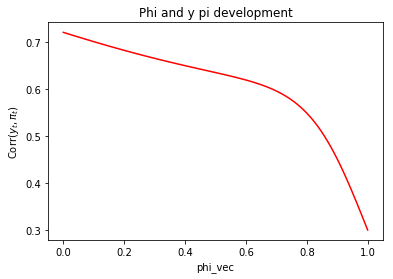

In [37]:
# a. Initialize 
N=100
phi_vec = np.linspace(0,1,N)
y_pi = np.zeros(N)

# b. Simulate
for i in range(N): 
    cor=Corrplot(par['alpha'],par['b'],par['gamma'],par['h'],phi_vec[i],1000) 
    y_pi[i]=cor

# c. Plot
plt.plot(phi_vec,y_pi, color='red')
plt.xlabel('phi_vec')
plt.ylabel('Corr($y_t, \pi_t$)')
plt.title('Phi and y pi development')
plt.show()   

The plot shows the negative relationship between the correlation of y and $\pi$ and $\phi$. 

Next, we need to determine the value of $\phi$ that yields a correlation of 0.31. We define a function that creates the root-finding problem, and then optimize it to find the value of phi. 

In [38]:
# Define function to be optimized
def opt_correlation(K):
    return (Corrplot(par['alpha'],par['b'],par['gamma'],par['h'],K,1000)-0.31)**2

In [39]:
# Optimize
x0=0
rootfinder=optimize.minimize(opt_correlation,x0)
rootfinder.x

array([0.9936101])

This means that the value of $\phi=0.9936$ yields a correlation between $y_{t}$ and $\pi_{t}$ of 0.31. 

## Question 6

Now we use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

First, we define the shocks s and v as functions that take their variance as input.  

In [40]:
 def v_stødny(sigmaX):
    # a. Initialize vector
    N=1000
    v_vec = np.empty(N)
    v_vec[0]=0
    
    # b. Draw 
    x_t = np.random.normal(0,sigmaX, size=N)
    for i in range(1,N):
        v_t = par['delta']*v_vec[i-1]+x_t[i] 
        v_vec[i] = v_t   
    return v_vec    
        
def s_stødny(sigmaC):
    N=1000
    s_vec = np.empty(N)
    s_vec[0]=0
    c_t = np.random.normal(0,sigmaC, size=N)
    for i in range(1,N):    
        s_t = par['omega']*s_vec[i-1]+c_t[i]
        s_vec[i]=s_t
    return s_vec


Next, we define a function that finds the optimal shock variances and value of $\phi$ in order to get as close the the US business cycle values as possible. 

In [41]:
def Optimal_parameters(parameters):
    ### Function takes as inputs a tuple containing phi, sigma_x and sigma_c. 
    ### Returns the sum of squared distances between the estimated statistics and the US business cycle values, which will be minimized. 
    phi,sigmaX,sigmaC = parameters
   
    # a. Create shock vectors
    v_vec=v_stødny(sigmaX)
    s_vec=s_stødny(sigmaC)
    
    # b. Initialize vectors, parameters and start values 
    y_star_vec=np.empty(1000)
    pi_star_vec=np.empty(1000)
    alpha=par['alpha']
    beta=par['b']
    gamma=par['gamma']
    h=par['h']
    y_star_vec[0]=0
    pi_star_vec[0]=0
    v_t=0.1
    
    # c. Simulate model 1000 times and save results to vector
    for i in range(1,1000):
        y_star2=y_star(alpha,beta,gamma,h,phi,y_star_vec[i-1],s_vec[i-1],pi_star_vec[i-1],s_vec[i],v_vec[i])
        y_star_vec[i]=y_star2
        pi_star2=pi_star(alpha,beta,gamma,h,phi,y_star_vec[i-1],s_vec[i-1],pi_star_vec[i-1],s_vec[i],v_vec[i])
        pi_star_vec[i]=pi_star2
    
    # d. Calculate squared distances of the five statistics
    ## i. Variance of y
    y_var_min = (np.var(y_star_vec)-1.64)**2
    
    ## ii. Variance of pi 
    pi_var_min = (np.var(pi_star_vec)-0.21)**2
    
    ## iii. Correlation between y and pi
    y_pi_corr = np.corrcoef(y_star_vec,pi_star_vec)
    corrcoef_min=(y_pi_corr[0,1]-0.31)**2
    
    ## iv. Autoorrelation of pi
    pi_star_vec_autocorr = pi_star_vec[1:]
    pi_star_vec = pi_star_vec[:-1]
    pi_autocorr_min = (np.corrcoef(pi_star_vec_autocorr,pi_star_vec)[0,1]-0.84)**2
   
    ## v. Autocorrelation of y 
    y_star_vec_autocorr = y_star_vec[1:]
    y_star_vec = y_star_vec[:-1]
    y_autocorr_min = (np.corrcoef(y_star_vec_autocorr,y_star_vec)[0,1]-0.48)**2    
    
    # e. Sum squared distances
    k=np.sum(np.array([y_var_min,pi_var_min,corrcoef_min,pi_autocorr_min,y_autocorr_min]))
    return k

We calculate the sum in the function above to be able to solve the multiple root-finding problems at once. We use the Nelder-Mead method for optimization as it does not require differentiability of the function, which (it seems) is not fulfilled.

In [42]:
x0=[0.3,0.3,0.3]

opt=optimize.minimize(Optimal_parameters,x0,method='Nelder-Mead',options={'disp':True})
results = opt.x
print(results)

[0.27566529 0.26890947 0.34990398]


The optimization yields a result of optimal values: $(\phi, \sigma_x, \sigma_c) = (0.2756, 0.2689, 0.3499)$, which should get the parameters closest possible to the desired values. To check whether the values we found gives us a solution close to what we were looking for, we define the Optimal_parameters function again, but this time we make it return the estimates values.

In [43]:
def Opt_param_check(parameters):
    ### (same as function Optimal_parameters, but returns statistics of estimated values.)
    # Initialize
    phi,sigmaX,sigmaC = parameters
    alpha=par['alpha']
    beta=par['b']
    gamma=par['gamma']
    h=par['h']
    v_vec=v_stødny(sigmaX)
    s_vec=s_stødny(sigmaC)
    y_star_vec=np.empty(1000)
    pi_star_vec=np.empty(1000)
    v_t=0.1
    y_star_vec[0]=0
    pi_star_vec[0]=0
    
    # Simulate to estimate values
    for i in range(1,1000):
        y_star2=y_star(alpha,beta,gamma,h,phi,y_star_vec[i-1],s_vec[i-1],pi_star_vec[i-1],s_vec[i],v_vec[i])
        y_star_vec[i]=y_star2
        pi_star2=pi_star(alpha,beta,gamma,h,phi,y_star_vec[i-1],s_vec[i-1],pi_star_vec[i-1],s_vec[i],v_vec[i])
        pi_star_vec[i]=pi_star2
    
    # Calculate statistics
    y_var_min = (np.var(y_star_vec))
    pi_var_min = (np.var(pi_star_vec))
    y_pi_corr = np.corrcoef(y_star_vec,pi_star_vec)
    corrcoef_min=(y_pi_corr[0,1])
    pi_star_vec_autocorr = pi_star_vec[1:]
    pi_star_vec = pi_star_vec[:-1]
    pi_autocorr_min = (np.corrcoef(pi_star_vec_autocorr,pi_star_vec)[0,1])
    y_star_vec_autocorr = y_star_vec[1:]
    y_star_vec = y_star_vec[:-1]
    y_autocorr_min = (np.corrcoef(y_star_vec_autocorr,y_star_vec)[0,1])    
    
    #k=np.sum(np.array([y_var_min,pi_var_min,corrcoef_min,pi_autocorr_min,y_autocorr_min]))
    kk=np.array([y_var_min,pi_var_min,corrcoef_min,pi_autocorr_min,y_autocorr_min])
    return kk

In [44]:
Opt_param_check(results)

array([0.4158    , 0.62217238, 0.65795245, 0.9076139 , 0.60895816])

Desired values:
1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

Comparing our optimization results with the desired values presented above, we conclude that we get somewhat close to some of the values, but are quite far from others. Especially, our variances are quite different from the US business cycle data, but our optimization has been a bit more successful in getting the correlation coefficients right. 

## 3. Exchange Economy 

In [45]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

### 3.1
As the preferences are Cobb-Douglas, we note that the variables 'betas' reflect the budget shares spent on each good. Hence, we plot betas to illustrate the budget shares across agents.

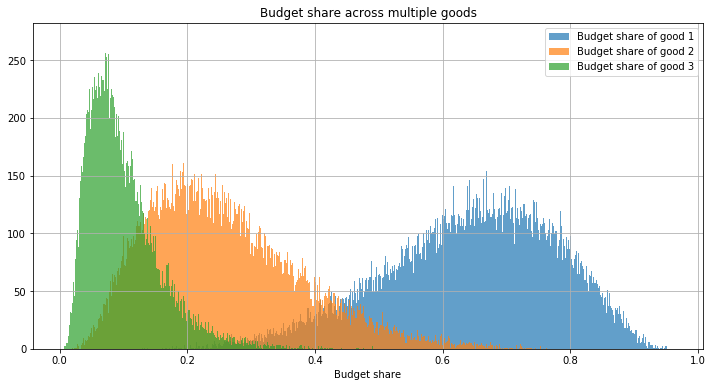

In [46]:
# a. Create figure
fig_budget_shares = plt.figure(figsize=(12,6))
his = fig_budget_shares.add_subplot(1,1,1)
his.hist(betas[:,0],bins =1000, alpha=0.7 ,label = 'Budget share of good 1');
his.hist(betas[:,1],bins =1000, alpha=0.7 ,label = 'Budget share of good 2');
his.hist(betas[:,2],bins =1000, alpha=0.7 ,label = 'Budget share of good 3');

# b. format
his.set_title('Budget share across multiple goods')
his.legend(loc='upper right')
his.set_xlabel('Budget share')
his.grid(True)

### 3.2

First, we define the demand functions.

In [47]:
def demand_good1_function(p1,p2,e1,e2,e3):
    ### Takes as input the prices and arrays for endownments. 
    ### Returns an array of quantity demanded for the good, for each of the N persons.
    I = p1*e1 + p2*e2 + e3
    return betas[:,0]*I/p1

def demand_good2_function(p1,p2,e1,e2,e3):
    ### Takes as input the prices and arrays for endownments. 
    ### Returns an array of quantity demanded for the good, for each of the N persons.
    I = p1*e1 + p2*e2 + e3
    return betas[:,1]*I/p2

def demand_good3_function(p1,p2,e1,e2,e3):
    ### Takes as input the prices and arrays for endownments. 
    ### Returns an array of quantity demanded for the good, for each of the N persons.
    I = p1*e1 + p2*e2 + e3
    return betas[:,2]*I

Then we define the excess demand functions as given in the assignment for all three goods.

In [48]:
def excess_demand_good1(p1,p2,e1,e2,e3):
    ### Calls demand function and returns the excess demand as a float. 
    demand = np.sum(demand_good1_function(p1,p2,e1,e2,e3))
    supply = np.sum(e1)
    excess_demand = demand - supply 
    return excess_demand

def excess_demand_good2(p1,p2,e1,e2,e3):
    ### Calls demand function and returns the excess demand as a float. 
    demand = np.sum(demand_good2_function(p1,p2,e1,e2,e3))
    supply = np.sum(e2)
    excess_demand = demand - supply 
    return excess_demand

def excess_demand_good3(p1,p2,e1,e2,e3):
    ### Calls demand function and returns the excess demand as a float. 
    demand = np.sum(demand_good3_function(p1,p2,e1,e2,e3))
    supply = np.sum(e3)
    excess_demand = demand - supply 
    return excess_demand

We then create a function that calculates the excess demand functions for good 1 and 2 based on the prices of both goods.

In [49]:
# a. Create pricevectors with 100 values between 0.1 and 10 for both p1 and p2. 
#    p1,p2 > 0 to avoid division by zero in the demand functions.
p1_vec = np.linspace(0.1,10,100)
p2_vec = np.linspace(0.1,10,100) 

# b. Initialize matrices that get filled out below. 
excess_demand_g1 = np.zeros([100,100])
excess_demand_g2 = np.zeros([100,100])

# c. Define function that fills out the excess demand grids for both goods. 
def get_excess_demand_grid(p1,p2,e1,e2,e3):
    ### Takes as inputs the price- and endowment vectors.
    ### Calculates the excess demand for all combinations of prices by looping through the price vectors. 
    ### Returns the excess demand grids. 
    
    for i,p1 in enumerate(p1_vec):
        for j,p2 in enumerate(p2_vec):
            excess_demand_g1[i,j] = excess_demand_good1(p1_vec[i],p2_vec[j],e1,e2,e3)
            excess_demand_g2[i,j] = excess_demand_good2(p1_vec[i],p2_vec[j],e1,e2,e3)
    return excess_demand_g1,excess_demand_g2  
 
# d. Run function to update grids 
get_excess_demand_grid(p1_vec,p2_vec,e1,e2,e3)

(array([[ 336181.01951616,  368112.48462628,  400043.94973639, ...,
         3433533.13519699, 3465464.6003071 , 3497396.06541721],
        [ 159171.97728647,  175137.70984153,  191103.44239658, ...,
         1707848.03512688, 1723813.76768194, 1739779.500237  ],
        [ 100168.96320991,  110812.78491328,  121456.60661665, ...,
         1132619.66843685, 1143263.49014022, 1153907.31184359],
        ...,
        [ -14224.63550996,  -13898.80423333,  -13572.97295669, ...,
           17380.99832352,   17706.82960015,   18032.66087678],
        [ -14261.12469616,  -13938.58464454,  -13616.04459292, ...,
           17025.26031072,   17347.80036234,   17670.34041396],
        [ -14296.88409863,  -13977.56944753,  -13658.25479642, ...,
           16676.63705818,   16995.95170928,   17315.26636038]]),
 array([[ 105934.60974196,   34527.38937598,   10724.98258732, ...,
          -35422.54077845,  -35437.2608816 ,  -35451.68658268],
        [ 118801.75823209,   40960.96362104,   15014.03208403

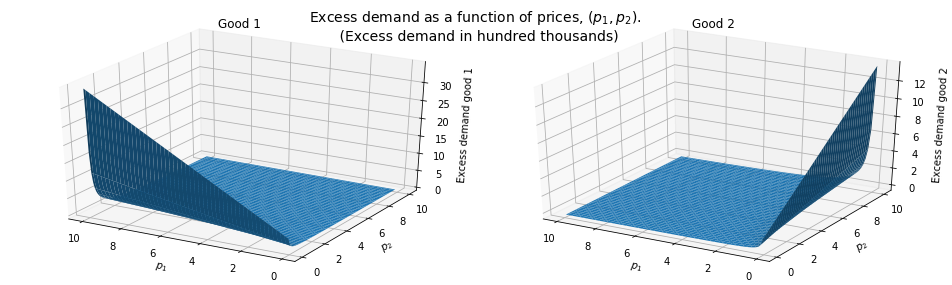

In [50]:
# a. Create a price grid to be able to create a 3d plot
p1_grid,p2_grid = np.meshgrid(p1_vec, p2_vec)

# b. Create plots 
fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Excess demand as a function of prices, $(p_1,p_2)$. \n (Excess demand in hundred thousands)', fontsize=14)
#fig.subplots_adjust(top=2)

# b1. Excess demand good 1 
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(p1_grid,p2_grid,excess_demand_g1/100000)
ax1.invert_xaxis()
ax1.set_title('Good 1')
ax1.set_zlabel('Excess demand good 1')
ax1.set_xlabel('$p_1$')
ax1.set_ylabel('$p_2$')

# b2. Excess demand good 2
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(p1_grid,p2_grid,excess_demand_g2/100000)
ax2.invert_xaxis()
ax2.set_title('Good 2')
ax2.set_zlabel('Excess demand good 2')
ax2.set_xlabel('$p_1$')
ax2.set_ylabel('$p_2$')

plt.tight_layout()

The plots above show the excess demand for each good as a function of the prices. When there is more demand for a good than supply of it, the excess demand is positive. We see from the plots that excess demand for a good drives up the good's price in the exchange economy. 

### 3.3

To find the Walras-equilibrium prices, we define a function with the specified tatônnement process. 

In [51]:
def find_equilibrium(p1_guess,p2_guess,betas,e1,e2,e3,k,kappa=0.5,eps=1e-8,maxiter=1000,printer=True):
    ### Takes as inputs intial guesses for p1 and p2, and vectors for betas and endowments. 
    ### Kappa determines the step size between iterations and eps is the tolerance. 
    ### Set printer to False to avoid printing results after each iteration. 
    ### Source: Problem set 2
    
    N = 50000
    t = 0
    while True:

        # a. Calculate excess demand
        Z1 = excess_demand_good1(p1_guess,p2_guess,e1,e2,e3)
        Z2 = excess_demand_good2(p1_guess,p2_guess,e1,e2,e3)
        
        # b. Stop?
        if  (np.abs(Z1) < eps and np.abs(Z2) < eps) or t >= maxiter:
            if printer == True:
                print(f'{t:3d}: (p1,p2) = ({p1_guess:12.5f}, {p2_guess:12.5f}) -> excess demand (x1,x2) -> ({Z1:14.5f},{Z2:14.5f})')
            break    
    
        # c. Update prices
        p1_guess = p1_guess + kappa*Z1/N
        p2_guess = p2_guess + kappa*Z2/N
        
        # d. Return 
        if printer == True:
            if t < 5 or t%100 == 0:
                print(f'{t:3d}: (p1,p2) = ({p1_guess:12.5f},{p2_guess:12.5f}) -> excess demand (x1,x2) -> ({Z1:14.5f},{Z2:14.5f}')
            elif t == 5:
                print('   ...')
            
        t += 1    

    return p1_guess, p2_guess

In [52]:
find_equilibrium(1,1,betas,e1,e2,e3,1,kappa=0.5,eps=1e-8,maxiter=1000,printer=True)

  0: (p1,p2) = (     1.46303,     0.88982) -> excess demand (x1,x2) -> (   46303.06210,  -11017.95328
  1: (p1,p2) = (     1.69902,     0.87862) -> excess demand (x1,x2) -> (   23598.79584,   -1120.07648
  2: (p1,p2) = (     1.87535,     0.90654) -> excess demand (x1,x2) -> (   17632.98644,    2791.77377
  3: (p1,p2) = (     2.02308,     0.94727) -> excess demand (x1,x2) -> (   14773.26450,    4072.82521
  4: (p1,p2) = (     2.15343,     0.99045) -> excess demand (x1,x2) -> (   13034.77884,    4318.76231
   ...
100: (p1,p2) = (     5.40207,     2.21042) -> excess demand (x1,x2) -> (    1206.80468,     451.18041
200: (p1,p2) = (     6.09952,     2.47096) -> excess demand (x1,x2) -> (     383.07271,     143.00001
300: (p1,p2) = (     6.33963,     2.56057) -> excess demand (x1,x2) -> (     141.90474,      52.95100
400: (p1,p2) = (     6.43077,     2.59458) -> excess demand (x1,x2) -> (      55.12603,      20.56704
500: (p1,p2) = (     6.46649,     2.60790) -> excess demand (x1,x2) -> (   

The Walras-equilibrium prices are evaluated in the function above to $(p_1,p_2) = (6.48,2.61)$. 

### 3.4

To calculate the utility for each of the N agents of the economy, we define a function that returns all N utilities in an array. 

In [53]:
def utility(betas,gamma,e1,e2,e3):
    ### Takes array of betas, parameter gamma and arrays with endowments for all three goods as input. 
    ### Returns array with the N utilities. 
    
    #a. Calculate equilibrium prices
    eq_p1, eq_p2 = find_equilibrium(1,1,betas,e1,e2,e3,1,kappa=0.5,eps=1e-8,maxiter=1000,printer=False)
    eq_p3 = 1
    
    #b. Calculate demand for the three goods
    demand_x1_array = demand_good1_function(eq_p1,eq_p2,e1,e2,e3)
    demand_x2_array = demand_good2_function(eq_p1,eq_p2,e1,e2,e3)
    demand_x3_array = demand_good3_function(eq_p1,eq_p2,e1,e2,e3)
    
    #c. Calculate utility 
    u_array = (demand_x1_array**betas[:,0] * demand_x2_array**betas[:,1] * demand_x3_array**betas[:,2])**gamma
    
    return u_array

We use the array returned by the function defined above to plot the distribution of utility across agents in the economy. 

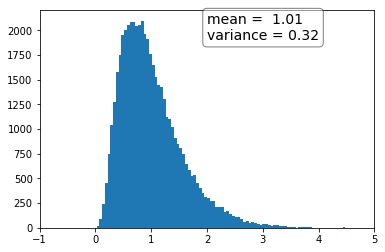

In [54]:
# a. Get the array of utilities from function
u_array = utility(betas,gamma,e1,e2,e3)

# b. Calculate statistics 
mean = np.mean(u_array)
variance = np.var(u_array)
 
# b. Plot utility distribution
fig, ax = plt.subplots()  
properties = dict(boxstyle='round', facecolor='white', alpha=0.5)   
textstr = '\n'.join((r'mean =  %.2f' % (mean, ), (r'variance = %.2f' % (variance, ))))
plt.xlim(-1,5)
ax.text(0.5,0.99,textstr,transform=ax.transAxes,fontsize=14,verticalalignment='top', bbox=properties)
plt.hist(u_array,bins=100);

### 3.5

To distribute all goods evenly, we sum all endowments of each goods and divide by N. Then we create new arrays with the new equally distributed endowments, that we will use to calculate equilibrium prices. 

In [55]:
# Define arrays with the equal endowments 
a = np.sum(e1)/(50000)
equal_e1 = np.full((50000,),a)

b = np.sum(e2)/(50000)
equal_e2 = np.full((50000,),b)

c = np.sum(e3)/(50000)
equal_e3 = np.full((50000,),c)

In [56]:
# Find Walras-prices with equal distribution of endowments 
find_equilibrium(1,1,betas,equal_e1,equal_e2,equal_e3,1,kappa=0.5,eps=1e-8,maxiter=1000)

  0: (p1,p2) = (     1.46330,     0.88963) -> excess demand (x1,x2) -> (   46330.45323,  -11036.77294
  1: (p1,p2) = (     1.69929,     0.87843) -> excess demand (x1,x2) -> (   23598.83905,   -1119.76885
  2: (p1,p2) = (     1.87560,     0.90641) -> excess demand (x1,x2) -> (   17631.05086,    2797.68466
  3: (p1,p2) = (     2.02332,     0.94720) -> excess demand (x1,x2) -> (   14771.25631,    4079.23229
  4: (p1,p2) = (     2.15364,     0.99045) -> excess demand (x1,x2) -> (   13032.89004,    4324.47956
   ...
100: (p1,p2) = (     5.40056,     2.21137) -> excess demand (x1,x2) -> (    1205.32714,     451.24420
200: (p1,p2) = (     6.09685,     2.47183) -> excess demand (x1,x2) -> (     382.18809,     142.86642
300: (p1,p2) = (     6.33630,     2.56132) -> excess demand (x1,x2) -> (     141.41050,      52.83947
400: (p1,p2) = (     6.42707,     2.59523) -> excess demand (x1,x2) -> (      54.86556,      20.49816
500: (p1,p2) = (     6.46260,     2.60851) -> excess demand (x1,x2) -> (   

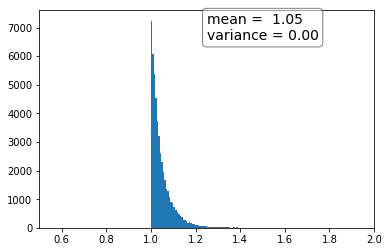

In [57]:
# a. Get the array of utilities from function
u_equal = utility(betas,gamma,equal_e1,equal_e2,equal_e3)

# b. Calculate statistics 
mean = np.mean(u_equal)
variance = np.var(u_equal)
 
# b. Plot utility distribution
fig, ax = plt.subplots()  
properties = dict(boxstyle='round', facecolor='white', alpha=0.5)   
textstr = '\n'.join((r'mean =  %.2f' % (mean, ), (r'variance = %.2f' % (variance, ))))
plt.xlim(0.5,2)
ax.text(0.5,0.99,textstr,transform=ax.transAxes,fontsize=14,verticalalignment='top', bbox=properties)
plt.hist(u_equal,bins=100);

The Walras equilibrium prices with equally distributed endowments are very close to the exponentially distributed ones. The difference in the equilibria, however, is clearly to be found in the distribution of goods. 
The histogram above shows that the equal distribution of goods yields a higher mean and a much lower variance than when the endowments are distributed exponentially. As all agents get the same income, their relative utility is determined by their betas. The effect of the size of $\gamma$ is illustrated in the interactive histogram below.

In [58]:
def _create_histogram(gamma):
    # a. Get array of utilities
    u_array = utility(betas,gamma,e1,e2,e3)
    
    # b. Calculate mean and variance
    fig, ax = plt.subplots()
    mean = np.mean(u_array)
    variance = np.var(u_array)
    
    # c. Plot distribution of utility
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    textstr = '\n'.join((r'mean =  %.2f' % (mean, ),(r'variance = %.2f' % (variance, ))))
    plt.hist(u_array,bins=100)
    plt.xlim(0,7)
    plt.title('Distribution of utility across agents')
    plt.xlabel('Utility')
    plt.ylabel('Number of agents')
    ax.text(0.5,0.99,textstr,transform=ax.transAxes,fontsize=14,verticalalignment='top', bbox=props)   

Please note that we have had trouble running two interactive plots in one notebook. The interactive plots seem to refer to one another. If you cannot use the sliders, please restart kernal.

In [59]:
plot2 = interact(_create_histogram,
    gamma=widgets.FloatSlider(description='$\gamma$',min=0.01, max=0.99,step=0.1,value=0.8)
    );
plot2

interactive(children=(FloatSlider(value=0.8, description='$\\gamma$', max=0.99, min=0.01), Output()), _dom_cla…

<function __main__._create_histogram(gamma)>

The plot above shows how the distribution of utility changes with $\gamma$. As $\gamma$ gets smaller, the variance of the utility converges to zero and likewise, a larger $\gamma$ yields a larger variance in the distribution. 

In [60]:
#Turn off nice printing
sm.init_printing(use_unicode=False)